In [39]:
# librerías default
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# librerias TextMining
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud

In [28]:
# cargar el dataframe de los tweets

df = pd.read_csv('tw_source.csv', encoding='latin1', header=None)

df.columns = ['Valor', 'id', 'FechaHora', 'Fuente', 'Usuario', 'Tweet'] 

df.head()

,Valor,id,FechaHora,Fuente,Usuario,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [29]:
df.shape

(1600000, 6)

### Extraer 3 usuarios más populares dentro del dataframe

In [30]:
df['Menciones'] = df['Tweet'].apply(lambda x: re.findall(r'@\w+', x))

menciones_expandidas = df.explode('Menciones')

usuarios_populares = menciones_expandidas['Menciones'].value_counts().head(3)

print('Los 3 usuarios más populares dentro del dataframe son:')
usuarios_populares

Los 3 usuarios más populares dentro del dataframe son:


Menciones
@mileycyrus    4500
@tommcfly      3887
@ddlovato      3467
Name: count, dtype: int64

### Desarrollar corpus que contenga:

* Content: Tweet. 
* Metadata: ID, Timestamp, Length (este valor hay que calcularlo).

In [31]:
lista_top_usuarios = usuarios_populares.index.tolist()

# Crear corpus

corpus = {}

for usuario in lista_top_usuarios:
    tweet_usuario = menciones_expandidas[menciones_expandidas['Menciones'] == usuario]

    usuario_corpus = tweet_usuario[['id', 'FechaHora', 'Tweet']]
    usuario_corpus['Length'] = usuario_corpus['Tweet'].apply(len)

    corpus[usuario] = usuario_corpus

    print(f"Información para {usuario}:")
    print(usuario_corpus.head(), "\n")

Información para @mileycyrus:
              id                     FechaHora  \
1021  1468063101  Mon Apr 06 23:30:57 PDT 2009   
2014  1468286517  Tue Apr 07 00:45:20 PDT 2009   
2073  1468297110  Tue Apr 07 00:49:07 PDT 2009   
2080  1468298918  Tue Apr 07 00:49:44 PDT 2009   
2156  1468318249  Tue Apr 07 00:56:41 PDT 2009   

                                                  Tweet  Length  
1021  @mileycyrus hahaha dont be like that one time ...     107  
2014  @mileycyrus i have the same problem, but it's ...     137  
2073  @mileycyrus I guess counting sheep didn't work...      72  
2080  @mileycyrus I would too if it meant spending a...     100  
2156  @mileycyrus AWWW u seriously have the cutest d...     112   

Información para @tommcfly:
              id                     FechaHora  \
1690  1468210813  Tue Apr 07 00:19:09 PDT 2009   
1789  1468233211  Tue Apr 07 00:26:52 PDT 2009   
2514  1468391638  Tue Apr 07 01:23:07 PDT 2009   
3029  1468502040  Tue Apr 07 02:03:41 PDT 2

C:\Users\julit\AppData\Local\Temp\ipykernel_23696\2593335115.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usuario_corpus['Length'] = usuario_corpus['Tweet'].apply(len)
C:\Users\julit\AppData\Local\Temp\ipykernel_23696\2593335115.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usuario_corpus['Length'] = usuario_corpus['Tweet'].apply(len)
C:\Users\julit\AppData\Local\Temp\ipykernel_23696\2593335115.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


### Análisis de porque citan a estos usuarios

In [33]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julit\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julit\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\julit\AppData\Roaming\nltk_data...


True

In [34]:
# Iniciar lematizador y stopwords

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [35]:
# Definimos la función para procesar texto para remover stopwords y aplicar lematizador

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalnum() and token.lower() not in stop_words]
    return tokens

In [36]:
# Guardamos el contexto para cada usuario en un diccionario

usuario_contexto = {}

# Extraer las palabras que se encuentran en la mencion de los usuarios
for usuario in lista_top_usuarios:
    user_tweets = corpus[usuario]['Tweet'].tolist()
    context_words = []

    for tweet in user_tweets:
        tokens = preprocess_text(tweet)
        if usuario.strip('@') in tokens:
            user_index = tokens.index(usuario.strip('@'))
            context_words.extend(tokens[max(0, user_index-5):user_index])
            context_words.extend(tokens[user_index+1:min(len(tokens), user_index+4)])

    
    usuario_contexto[usuario] = Counter(context_words)


    print(f"Palabras más comunes para el usuario: {usuario}:")
    print(usuario_contexto[usuario].most_common(10), "\n")

Palabras más comunes para el usuario: @mileycyrus:
[('miley', 572), ('http', 490), ('love', 391), ('u', 207), ('good', 187), ('hey', 173), ('quot', 173), ('hope', 138), ('vote', 134), ('come', 132)] 

Palabras más comunes para el usuario: @tommcfly:
[('tom', 561), ('say', 190), ('http', 182), ('hey', 154), ('u', 147), ('please', 142), ('good', 138), ('love', 122), ('guy', 108), ('reply', 102)] 

Palabras más comunes para el usuario: @ddlovato:
[('demi', 430), ('love', 246), ('http', 182), ('u', 173), ('wish', 170), ('hey', 120), ('come', 114), ('hope', 109), ('im', 108), ('please', 104)] 



### Wordcloud

Top 10 WordCloud para @mileycyrus


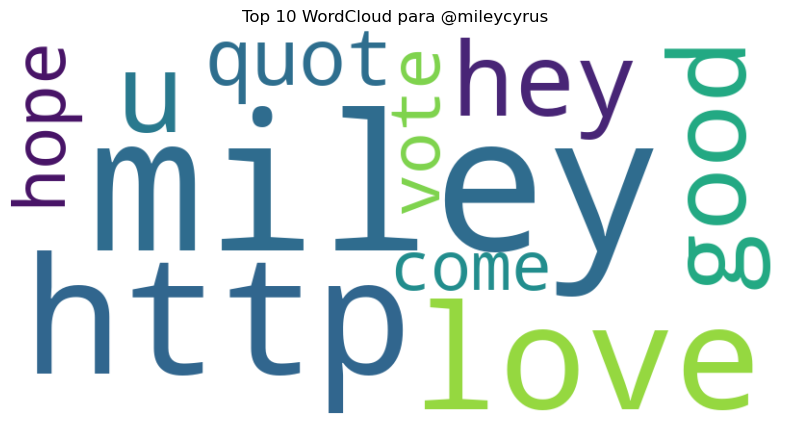

Top 10 WordCloud para @tommcfly


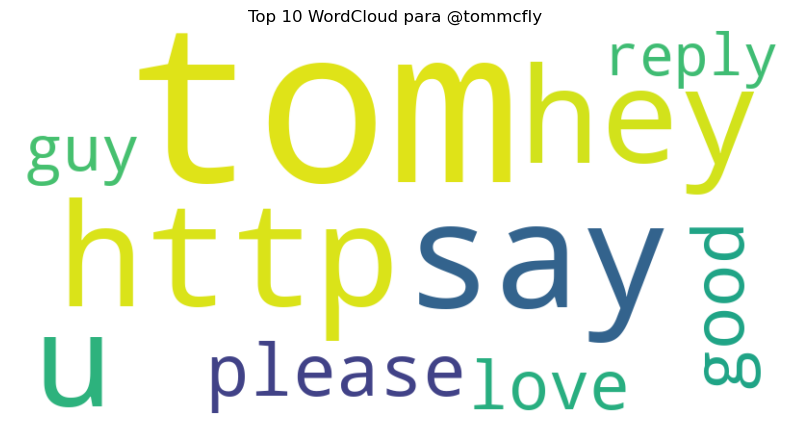

Top 10 WordCloud para @ddlovato


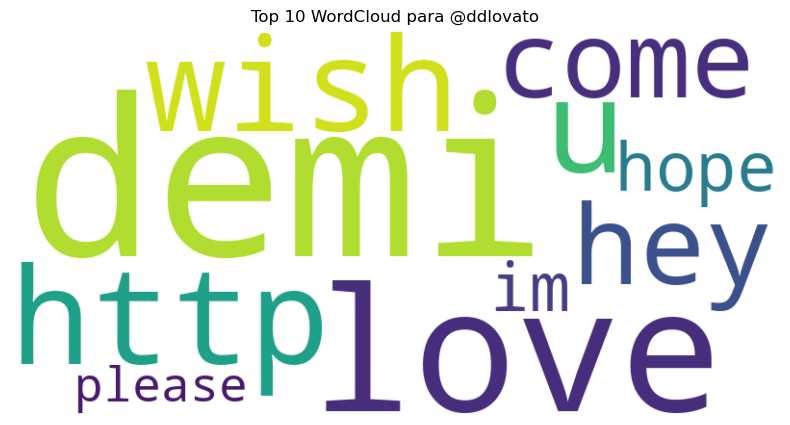

In [50]:
# Definimos la función para generar y mostrar el WordCloud
def generar_wordcloud(contador_contexto, titulo):
    # Filtramos el top 10 de palabras más frecuentes
    top_10_palabras = dict(sorted(contador_contexto.items(), key=lambda item: item[1], reverse=True)[:10])
    
    # Generamos el WordCloud solo con el top 10
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_10_palabras)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo)
    plt.show()

# WordClouds de los tres usuarios más populares
for usuario in lista_top_usuarios:
    print(f"Top 10 WordCloud para {usuario}")
    generar_wordcloud(usuario_contexto[usuario], f"Top 10 WordCloud para {usuario}")
